In [4]:
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression as LR, Ridge
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.metrics import r2_score as r2,mean_squared_error as MSE
warnings.filterwarnings('ignore')
from sklearn.model_selection import cross_val_score, GridSearchCV

C:\Users\Eugene\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\Eugene\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\Eugene\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\Eugene\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\Eugene\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expect

In [1]:
from scipy.stats import shapiro

In [5]:
df=pd.read_csv('train.csv')

In [12]:
test = df.Price
test1 = df.Square

In [8]:
shapiro(test)

(0.8999455571174622, 0.0)

In [9]:
import seaborn as sns

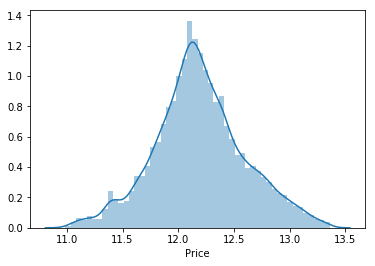

In [11]:
sns.distplot(np.log(test))

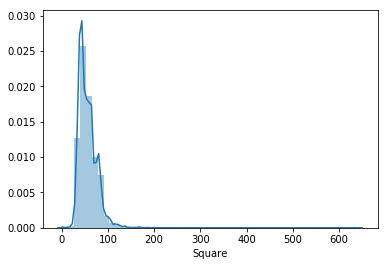

In [57]:
sns.distplot(test1)

In [26]:
data=df.copy()
data.drop(['Healthcare_1'],axis=1,inplace=True)

In [27]:
#гипотеза №2
data.loc[377,'Rooms']=2
data.loc[1454,'Rooms']=1
data.loc[8849,'Rooms']=2
data.loc[1397,'Rooms']=4
data.loc[1981,'Rooms']=5
data.loc[2269,'Rooms']=1
data.loc[3911,'Rooms']=1
data.loc[4366,'Rooms']=3
data.loc[6149,'Rooms']=1
data.loc[8834,'Rooms']=3
data.loc[4853,'Rooms']=1

In [28]:
def prepare_square(df):
    df.loc[df['Square']<(df['Rooms']*15),'Square']=df['Rooms']*15
   # df.loc[df['Square']>(df['Rooms']*40+20),'Square']=df['Rooms']*40+20
    return df

In [29]:
data=prepare_square(data)

In [30]:
data['price_square'] = data['Price'] / data['Square']

In [31]:
data['LifeSquare'] = data['LifeSquare'].fillna(data['LifeSquare'].mean())

In [32]:
train,test=train_test_split(data,test_size=0.3, random_state=54)

In [33]:
price_mean_by_distr_square=train.groupby(['DistrictId'],as_index=False).agg({'price_square':'mean'}).rename(columns={'price_square':'mean_price_by_ds'})

In [34]:
price_mean_by_distr_square.head()

,DistrictId,mean_price_by_ds
0,0,3906.105818
1,1,3241.334714
2,2,4572.065582
3,3,3677.887042
4,4,5035.442365


In [35]:
def join_price_mean(df,stats1,source_df):
    df=pd.merge(df,stats1,on=['DistrictId'],how='left')
    df['mean_price_by_ds']=df['mean_price_by_ds'].fillna(source_df['price_square'].mean())
    return df

In [36]:
train = join_price_mean(train,price_mean_by_distr_square,train)

In [356]:
correlation = train.corr()
print(correlation['Price'].sort_values(ascending=False))

Price               1.000000
price_square        0.594004
Rooms               0.574945
mean_price_by_ds    0.547718
Square              0.501587
LifeSquare          0.351455
Social_1            0.269122
Helthcare_2         0.257421
DistrictId          0.255619
Social_2            0.243029
Shops_1             0.182023
Floor               0.114123
Social_3            0.070582
HouseFloor          0.069637
KitchenSquare       0.018351
Id                  0.010019
HouseYear           0.005143
Ecology_1          -0.060091
Name: Price, dtype: float64


In [42]:
X_train=train[['Rooms','Square','DistrictId','Social_1','Helthcare_2','Social_2','mean_price_by_ds']]
y_train=np.log(train['Price'])

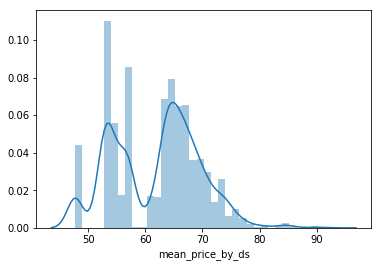

In [41]:
sns.distplot(X_train['mean_price_by_ds']**(.5))

In [43]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
#X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

C:\Users\Eugene\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [44]:
def rfr_model(X, y):
# Perform Grid-Search
    gsc = GridSearchCV(
        estimator=RF(),
        param_grid={
            'max_depth': range(3,7),
            'n_estimators': (10, 50, 75, 100),
            'min_samples_leaf':[3,5,7,10]
        },
        cv=3,  verbose=0,                         n_jobs=-1)
    
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    print(best_params)
    
rfr_model(X_train_scaled,y_train)

{'max_depth': 6, 'min_samples_leaf': 7, 'n_estimators': 100}


In [46]:
model3=RF(random_state=54,max_depth=6,n_estimators=100,min_samples_leaf=7)

In [425]:
from sklearn.cluster import KMeans


In [426]:
kmeans = KMeans(n_clusters=2,random_state=54)

labels_train = kmeans.fit_predict(X_train_scaled)



In [47]:
%%time
model3.fit(X_train_scaled,y_train)

Wall time: 640 ms


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=7, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=54, verbose=0, warm_start=False)

In [49]:
test = join_price_mean(test,price_mean_by_distr_square,train)

In [742]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 0 to 2999
Data columns (total 21 columns):
Id                  3000 non-null int64
DistrictId          3000 non-null int64
Rooms               3000 non-null float64
Square              3000 non-null float64
LifeSquare          3000 non-null float64
KitchenSquare       3000 non-null float64
Floor               3000 non-null int64
HouseFloor          3000 non-null float64
HouseYear           3000 non-null int64
Ecology_1           3000 non-null float64
Ecology_2           3000 non-null object
Ecology_3           3000 non-null object
Social_1            3000 non-null int64
Social_2            3000 non-null int64
Social_3            3000 non-null int64
Helthcare_2         3000 non-null int64
Shops_1             3000 non-null int64
Shops_2             3000 non-null object
Price               3000 non-null float64
price_square        3000 non-null float64
mean_price_by_ds    3000 non-null float64
dtypes: float64(9), int64(9), ob

In [50]:
X_test=test[['Rooms','Square','DistrictId','Social_1','Helthcare_2','Social_2','mean_price_by_ds']]
y_test=np.log(test['Price'])

In [51]:
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [52]:
X_test['y_pred_3']=model3.predict(X_test_scaled)

In [56]:
X_test.y_pred_3.value_counts()

12.090604    31
12.072024    26
12.253368    24
12.041264    23
11.771243    22
11.659885    19
11.857003    17
12.201732    15
12.137258    13
12.094130    13
12.211261    12
11.786508    12
12.021051    12
12.089896    10
11.771831     9
11.662433     9
12.894927     9
12.430004     9
12.020117     9
11.828733     9
11.875060     8
11.835710     8
12.064509     8
11.658130     8
11.775055     8
12.032443     8
12.144514     8
12.050348     8
11.670038     7
11.765297     7
             ..
12.369422     1
11.761996     1
12.106445     1
12.125395     1
12.181123     1
11.610071     1
12.094964     1
12.045516     1
12.260407     1
12.001780     1
12.114766     1
12.929835     1
12.623270     1
12.845204     1
12.182965     1
12.300874     1
12.045010     1
12.341020     1
11.991040     1
12.415211     1
12.354773     1
12.064474     1
12.102732     1
12.029843     1
12.342726     1
11.932140     1
12.170121     1
12.059910     1
12.610673     1
12.383977     1
Name: y_pred_3, Length: 

In [54]:
print('Случайный лес',MSE(y_test,X_test['y_pred_3']),r2(y_test,X_test['y_pred_3']))

Случайный лес 0.05602470332644998 0.6569835410419803


In [55]:
r2(y_train,model3.predict(X_train_scaled))

0.7302407936869482

In [431]:
labels_test = kmeans.predict(X_test_scaled)

In [432]:
model3.fit(X_train_scaled.loc[labels_train == 0], y_train[labels_train == 0])

y_test_pred_0 = model3.predict(X_test_scaled.loc[labels_test == 0])

In [433]:
model3.fit(X_train_scaled.loc[labels_train == 1], y_train[labels_train == 1])

y_test_pred_1 = model3.predict(X_test_scaled.loc[labels_test == 1])

In [434]:
y_test_all = np.hstack([y_test[labels_test == 0], y_test[labels_test == 1]])
y_test_pred_all = np.hstack([y_test_pred_0, y_test_pred_1])

r2(y_test_all, y_test_pred_all)

0.6930535017869215

In [435]:
y_train_all = np.hstack([y_train[labels_train == 0], y_train[labels_train == 1]])
y_train_pred_all = np.hstack([model3.predict(X_train_scaled.loc[labels_train == 0]), 
                              model3.predict(X_train_scaled.loc[labels_train == 1])])

r2(y_train_all, y_train_pred_all)

0.6718492390727081

In [483]:
price_mean_by_distr_square=data.groupby(['DistrictId','Rooms'],as_index=False).agg({'price_square':'mean'}).rename(columns={'price_square':'mean_price_by_ds'})

In [484]:
data = join_price_mean(data,price_mean_by_distr_square,data)

In [485]:
X = data[['Rooms','Square','DistrictId','Social_1','Helthcare_2','Social_2','mean_price_by_ds']]
y = data['Price']

In [486]:
X_scaled = pd.DataFrame(scaler.transform(X), columns=X.columns)

In [440]:
labels_train = kmeans.fit_predict(X_scaled)

In [487]:
model3.fit(X_scaled,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=5, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
           oob_score=False, random_state=54, verbose=0, warm_start=False)

# Загружаем тест

In [488]:
test=pd.read_csv('test.csv')

In [77]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
Id               5000 non-null int64
DistrictId       5000 non-null int64
Rooms            5000 non-null float64
Square           5000 non-null float64
LifeSquare       3959 non-null float64
KitchenSquare    5000 non-null float64
Floor            5000 non-null int64
HouseFloor       5000 non-null float64
HouseYear        5000 non-null int64
Ecology_1        5000 non-null float64
Ecology_2        5000 non-null object
Ecology_3        5000 non-null object
Social_1         5000 non-null int64
Social_2         5000 non-null int64
Social_3         5000 non-null int64
Healthcare_1     2623 non-null float64
Helthcare_2      5000 non-null int64
Shops_1          5000 non-null int64
Shops_2          5000 non-null object
dtypes: float64(7), int64(9), object(3)
memory usage: 742.3+ KB


In [52]:
test.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,8412.595400,51.279200,1.910000,56.449500,36.158810,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,4832.674037,44.179466,0.838594,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,1.000000,0.000000,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,4221.750000,21.000000,1.000000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,8320.500000,37.000000,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,12598.250000,77.000000,2.000000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,16795.000000,212.000000,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


In [277]:
test[test.Rooms > 5]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
2071,10793,23,6.0,110.750226,NaN,0.0,2,2.0,2015,0.014073,B,B,2,475,0,NaN,0,0,B
3217,4058,27,6.0,223.453689,104.113552,16.0,2,2.0,2017,0.041116,B,B,53,14892,4,NaN,1,4,B
3398,1435,111,17.0,255.000000,32.528342,8.0,15,17.0,1987,0.093443,B,B,23,4635,5,3300.0,2,4,B


In [489]:
data.loc[2406,'Rooms']=4
data.loc[2524,'Rooms']=3
data.loc[2071,'Rooms']=4
data.loc[3398,'Rooms']=6

In [490]:
test=prepare_square(test)

In [491]:
test=join_price_mean(test,price_mean_by_distr_square,data)

In [304]:
test_scaled = pd.DataFrame(scaler.transform(test), columns=test.columns)

ValueError: could not convert string to float: 'B'

In [650]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 20 columns):
Id                  5000 non-null int64
DistrictId          5000 non-null int64
Rooms               5000 non-null float64
Square              5000 non-null float64
LifeSquare          3959 non-null float64
KitchenSquare       5000 non-null float64
Floor               5000 non-null int64
HouseFloor          5000 non-null float64
HouseYear           5000 non-null int64
Ecology_1           5000 non-null float64
Ecology_2           5000 non-null object
Ecology_3           5000 non-null object
Social_1            5000 non-null int64
Social_2            5000 non-null int64
Social_3            5000 non-null int64
Healthcare_1        2623 non-null float64
Helthcare_2         5000 non-null int64
Shops_1             5000 non-null int64
Shops_2             5000 non-null object
mean_price_by_ds    5000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 820.3+ KB


In [85]:
test=join_stats1(test,stats1,data,mode='test')

In [86]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 20 columns):
Id               5000 non-null int64
DistrictId       5000 non-null int64
Rooms            5000 non-null float64
Square           5000 non-null float64
LifeSquare       5000 non-null float64
KitchenSquare    5000 non-null float64
Floor            5000 non-null int64
HouseFloor       5000 non-null float64
HouseYear        5000 non-null int64
Ecology_1        5000 non-null float64
Ecology_2        5000 non-null object
Ecology_3        5000 non-null object
Social_1         5000 non-null int64
Social_2         5000 non-null int64
Social_3         5000 non-null int64
Healthcare_1     2623 non-null float64
Helthcare_2      5000 non-null int64
Shops_1          5000 non-null int64
Shops_2          5000 non-null object
mean_price       5000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 820.3+ KB


In [492]:
temp=test[['Rooms','Square','DistrictId','Social_1','Helthcare_2','Social_2','mean_price_by_ds']]

In [493]:
temp_scaled = pd.DataFrame(scaler.transform(temp), columns=temp.columns)

In [652]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 7 columns):
Rooms               5000 non-null float64
Square              5000 non-null float64
DistrictId          5000 non-null int64
Social_1            5000 non-null int64
Helthcare_2         5000 non-null int64
Social_2            5000 non-null int64
mean_price_by_ds    5000 non-null float64
dtypes: float64(3), int64(4)
memory usage: 312.5 KB


In [447]:
labels_test = kmeans.fit_predict(temp_scaled)

In [448]:
model3.fit(X_scaled.loc[labels_train == 0], y[labels_train == 0])

y_test_pred_0 = model3.predict(temp_scaled.loc[labels_test == 0])

In [449]:
model3.fit(X_scaled.loc[labels_train == 1], y[labels_train == 1])

y_test_pred_1 = model3.predict(temp_scaled.loc[labels_test == 1])

In [494]:
test['Price']=model3.predict(temp_scaled)

In [495]:
test[['Id','Price']].to_csv('EChasovskih_predictions_test1.csv',index=False)

In [496]:
test.Price.value_counts()

124815.885778    120
177638.245147    119
156879.801809    117
178842.954118    112
173374.243859     85
141284.852963     78
127990.482306     72
157186.715051     61
178007.068926     45
202946.896402     43
225215.413691     43
125843.675373     41
141011.668915     40
215528.744066     38
201023.700369     38
194664.564066     38
177765.922975     36
129034.260706     34
173451.076366     30
226650.136939     30
325523.294332     30
225952.169575     29
179259.699676     28
160364.784190     28
198932.034407     28
190963.384585     28
177879.391098     27
178054.580250     26
214151.478310     25
221996.109388     25
                ... 
239895.532770      1
276999.978854      1
156280.167906      1
170853.462945      1
445145.392641      1
159296.541506      1
307832.378700      1
244361.820711      1
313156.390356      1
157863.413403      1
199622.296405      1
466242.777430      1
151492.119265      1
179178.583022      1
327134.160564      1
239372.008678      1
499464.722356

In [401]:
test

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,mean_price_by_ds,Price
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,...,B,11,2748,1,NaN,0,0,B,3021.675025,167508.563605
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,...,B,6,1437,3,NaN,0,2,B,3355.343060,202139.493944
2,5480,190,1.0,15.000000,15.948246,12.0,2,5.0,1909,0.000000,...,B,30,7538,87,4702.0,5,5,B,7919.443196,332494.654100
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,...,B,23,4583,3,NaN,3,3,B,4116.345095,304680.732542
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,...,B,2,629,1,NaN,0,0,A,2781.838969,125899.657290
5,7633,53,1.0,40.675627,NaN,1.0,21,21.0,1977,0.049637,...,B,34,7759,0,229.0,1,3,B,4821.509217,204033.604882
6,13329,23,2.0,68.099538,64.843025,1.0,2,17.0,1977,0.075779,...,B,6,1437,3,NaN,0,2,B,2284.108677,169389.171936
7,5502,32,2.0,48.193897,32.857644,6.0,5,14.0,1972,0.135650,...,B,46,7960,6,350.0,3,11,B,5008.861902,212849.385827
8,4220,96,3.0,72.277106,45.968758,9.0,17,17.0,1997,0.041116,...,B,53,14892,4,NaN,1,4,B,3970.219479,293429.169425
9,11538,6,3.0,80.219400,47.660260,9.0,13,17.0,2014,0.243205,...,B,5,1564,0,540.0,0,0,B,2918.027864,211096.905656
